<a href="https://colab.research.google.com/github/JulioFMDB/portfolio/blob/main/Analise_filmes_Julio_De_Bem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho para portfólio de Júlio De Bem

**[My LinkedIn](https://www.linkedin.com/in/juliodebem/)**

**[My GitHub](https://github.com/JulioFMDB)**

**[My personal Instagram](https://www.instagram.com/juliodebem)**

# Projeto - Análise de Notas de Filmes MovieLens

## Objetivo

Você atua no departamento de análise de dados em um Estúdio de Gravações Cinematográficas. O time de gestores(as) precisa de algumas informações sobre os votos do público a cerca dos últimos filmes. Existe uma pressão dos acionistas para que os próximos lançamentos tenham **notas altas** e uma **aceitação grande pelo público geral**.

Assim, com base nos registros disponibilizados, você terá que responder as seguintes perguntas:

**Perguntas**

   1. Quantos filmes por gênero estamos incluindo nesse levantamento?
   2. Quais são os títulos com maiores notas de avaliação pelo público?
   3. Qual a média de votos por filme?
   4. Filmes possuem nota superior a qual valor? Qual o percentual?
   5. Qual a popularidade dos filmes, considerando como regra o número de votos dividido pelo número de filmes?
   6. Quais os gêneros mais indicados para investir, considerando a audiência? Se olhar as notas, ainda seriam esses os filmes?

**Dados:**

- https://files.grouplens.org/datasets/movielens/ml-25m.zip
  - Vamos usar apenas as bases:
    - movies.csv
    - ratings.csv

## Análise Exploratória

Para iniciar essa análise, optei primeiramente por verificar os datasets e ir explorando/manipulando eles, para aí então responder os questionamentos.

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-25m.zip

--2022-08-30 13:56:16--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  81.6MB/s    in 3.2s    

2022-08-30 13:56:20 (77.5 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [2]:
!unzip /content/ml-25m.zip

Archive:  /content/ml-25m.zip
   creating: ml-25m/
  inflating: ml-25m/tags.csv         
  inflating: ml-25m/links.csv        
  inflating: ml-25m/README.txt       
  inflating: ml-25m/ratings.csv      
  inflating: ml-25m/genome-tags.csv  
  inflating: ml-25m/genome-scores.csv  
  inflating: ml-25m/movies.csv       


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
URL_movies = "ml-25m/movies.csv"
URL_ratings = "ml-25m/ratings.csv"

In [6]:
movies_raw = pd.read_csv(URL_movies)
movies_raw.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_raw = pd.read_csv(URL_ratings)
ratings_raw.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [8]:
print(movies_raw.shape)
print(ratings_raw.shape) #chamou a atenção que a ratings_raw deve ter muitas linhas

(62423, 3)
(25000095, 4)


In [9]:
ratings_raw.head() #vamos ver a ratings

#notei que é uma base que descreve cada voto de cada usuário para cada filme.
#para pensar: precisarei saber que voto o fulano deu para um filme qualquer?

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [10]:
df_rating_movie = pd.DataFrame(ratings_raw.groupby('movieId')['rating'].mean())
df_rating_movie.head()  #vamos agregar os filmes por nota média.

,rating
movieId,
1,3.893708
2,3.251527
3,3.142028
4,2.853547
5,3.058434


Aqui eu percebi que poderia ter usuários que tiveram péssimas intenções na hora de votar, e resolvi exclui-los da análise de notas

In [11]:
df_temp_user_count = pd.DataFrame(ratings_raw.groupby('userId')['userId'].count())
# df_temp_user_count.reset_index(inplace=True)
df_temp_user_count.rename(columns={"userId":"Qtde"}, inplace=True)
df_temp_user_count.head() 

,Qtde
userId,
1,70
2,184
3,656
4,242
5,101


In [12]:
df_temp_user_rating = pd.DataFrame(ratings_raw.groupby('userId')['rating'].mean().sort_values())
df_temp_user_rating.rename(columns={"rating":"nota_media"}, inplace=True)
df_temp_user_rating.head()

,nota_media
userId,
86408,0.5
113767,0.5
63044,0.5
9152,0.5
122697,0.5


In [13]:
df_temp_user_count = df_temp_user_count.merge(df_temp_user_rating, how='left', on='userId')
df_temp_user_count.head()

,Qtde,nota_media
userId,,
1,70,3.814286
2,184,3.630435
3,656,3.697409
4,242,3.378099
5,101,3.752475


In [14]:
selecao_bad_user = (df_temp_user_count['Qtde'] >= 30) & \
          (df_temp_user_count['nota_media'] < (df_temp_user_count['nota_media'].median())*.3)
df_temp_user_count[~selecao_bad_user].shape

(162511, 2)

**Abaixo estão os usuários mal intencionados, que provocam problemas na votação. Com seu ID, quantidade de votos, e a média de notas**

In [68]:
df_bad_users = df_temp_user_count[selecao_bad_user].sort_values(by='Qtde', ascending=False)
df_bad_users.to_csv('bad_users.csv')
df_bad_users

,Qtde,nota_media
userId,,
109210,2138,1.086997
123023,1237,1.099030
48508,929,1.073735
45040,884,1.008484
149767,872,1.034404
1484,869,1.052934
133607,787,1.064168
106065,585,0.994872
79194,510,1.098039


In [16]:
selecao_good_user = (df_temp_user_count['Qtde'] >= 30) & \
          (df_temp_user_count['nota_media'] > df_temp_user_count['nota_media'].quantile(q=.95))

In [17]:
df_bad_good_users = df_temp_user_count[selecao_good_user].sort_values(by='Qtde', ascending=False)
df_bad_good_users.to_csv('sweet_good_users.csv')

**Abaixo estão os usuários que dão muitas notas 5, e a quantidade de votos**

In [69]:
df_bad_good_users

,Qtde,nota_media
userId,,
75309,5525,5.000000
129440,1728,4.965567
139809,1372,4.553571
65901,1187,4.410278
57775,1153,4.690373
...,...,...
154805,30,4.500000
121278,30,4.433333
155159,30,4.433333


In [18]:
df_analysis = df_temp_user_count[~selecao_bad_user].copy()

In [19]:
df_analysis = df_analysis[~selecao_good_user].copy()

In [20]:
df_analysis.shape

(156418, 2)

In [21]:
df_analysis_ratings = df_analysis.copy()
del df_analysis

In [22]:
df_analysis_ratings.head()

,Qtde,nota_media
userId,,
1,70,3.814286
2,184,3.630435
3,656,3.697409
4,242,3.378099
5,101,3.752475


## Olhando o Movie.csv

In [23]:
movies_raw.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [24]:
df_movies = movies_raw.copy()

Para expressão regular, usei https://regex101.com/

In [25]:
df_movies['release'] = df_movies['title'].str.extract('\((\d{4})\)')
df_movies

,movieId,title,genres,release
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
62418,209157,We (2018),Drama,2018
62419,209159,Window of the Soul (2001),Documentary,2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018
62421,209169,A Girl Thing (2001),(no genres listed),2001


In [26]:
df_movies['title'] = df_movies['title'].apply(lambda x : x.split(" (")[0])
df_movies.head()

,movieId,title,genres,release
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [27]:
df_movies.set_index('movieId', inplace=True)
df_movies.head()

,title,genres,release
movieId,,,
1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji,Adventure|Children|Fantasy,1995
3,Grumpier Old Men,Comedy|Romance,1995
4,Waiting to Exhale,Comedy|Drama|Romance,1995
5,Father of the Bride Part II,Comedy,1995


In [28]:
df_genres = df_movies['genres'].str.get_dummies()
df_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209157,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
209159,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
209163,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [29]:
df_movies = df_movies.merge(df_genres, on='movieId', how='left')
df_movies.drop('genres', inplace=True, axis=1)
df_movies.head()

,title,release,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df_movies.rename(columns={'(no genres listed)':'outros'}, inplace=True)

In [31]:
df_movies.head()

,title,release,outros,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jumanji,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Grumpier Old Men,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Waiting to Exhale,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
ratings_raw.set_index('userId', inplace=True)

In [33]:
ratings_raw.head()

,movieId,rating,timestamp
userId,,,
1,296,5.0,1147880044
1,306,3.5,1147868817
1,307,5.0,1147868828
1,665,5.0,1147878820
1,899,3.5,1147868510


In [34]:
ratings_raw.shape

(25000095, 3)

In [35]:
trust_users = ratings_raw.index.isin(df_analysis_ratings.index)
df_final_ratings = ratings_raw[trust_users].copy()

In [36]:
df_final_ratings.head()

,movieId,rating,timestamp
userId,,,
1,296,5.0,1147880044
1,306,3.5,1147868817
1,307,5.0,1147868828
1,665,5.0,1147878820
1,899,3.5,1147868510


In [37]:
df_rating_movie = pd.DataFrame(df_final_ratings.groupby('movieId')['rating'].mean())

df_rating_movie.head()  #agreguei os filmes por nota média.

,rating
movieId,
1,3.873947
2,3.229371
3,3.131710
4,2.838665
5,3.044644


In [38]:
df_rating_movie['votes_qtty'] = df_final_ratings.groupby('movieId')['rating'].count()
df_rating_movie.head()

,rating,votes_qtty
movieId,,
1,3.873947,55667
2,3.229371,23789
3,3.131710,11681
4,2.838665,2501
5,3.044644,11558


In [39]:
df_movies = df_movies.merge(df_rating_movie, how='left', on='movieId')

In [40]:
df_movies.head()

,title,release,outros,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,votes_qtty
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,3.873947,55667.0
2,Jumanji,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,3.229371,23789.0
3,Grumpier Old Men,1995,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,3.131710,11681.0
4,Waiting to Exhale,1995,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.838665,2501.0
5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,3.044644,11558.0


## Quantos filmes por gênero estamos incluindo nesse levantamento?

In [41]:
df_movies.columns

Index(['title', 'release', 'outros', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'rating', 'votes_qtty'],
      dtype='object')

In [42]:
colunas = ['outros', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']

In [43]:
qtty_gen_movies = df_movies[colunas].sum().sort_values(ascending=False)

In [44]:
qtty_gen_movies

Drama          25606
Comedy         16870
Thriller        8654
Romance         7719
Action          7348
Horror          5989
Documentary     5605
Crime           5319
outros          5062
Adventure       4145
Sci-Fi          3595
Children        2935
Animation       2929
Mystery         2925
Fantasy         2731
War             1874
Western         1399
Musical         1054
Film-Noir        353
IMAX             195
dtype: int64

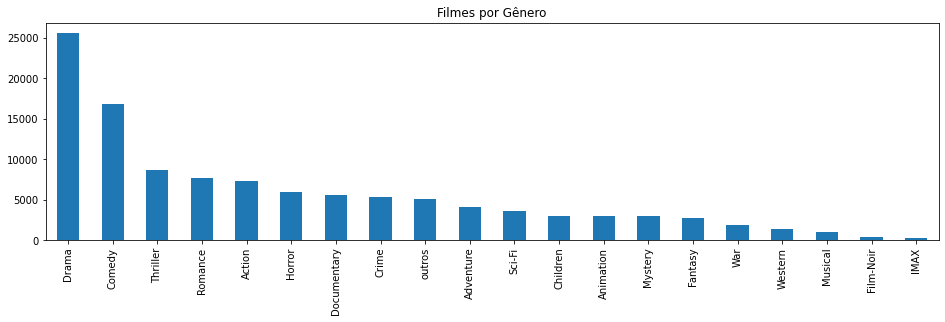

In [45]:
plt.figure(figsize=(16,4))
plt.title('Filmes por Gênero')
qtty_gen_movies.plot(kind='bar')
plt.show()

## Quais são os títulos com maiores notas de avaliação pelo público? & Qual a média de votos por filme?

In [46]:
df_top10 = df_movies[['title', 'votes_qtty', 'rating']].sort_values(by=['votes_qtty', 'rating'], \
                                                        ascending=[False, False]).head(10)

df_top10.set_index('title', inplace=True)
df_top10

,votes_qtty,rating
title,,
Forrest Gump,78622.0,4.025038
"Shawshank Redemption, The",78101.0,4.398631
Pulp Fiction,76931.0,4.170250
"Silence of the Lambs, The",71772.0,4.135526
"Matrix, The",69154.0,4.127419
Star Wars: Episode IV - A New Hope,66008.0,4.098193
Jurassic Park,62761.0,3.661812
Schindler's List,58219.0,4.232081
Braveheart,57488.0,3.985440


In [47]:
df_movies['votes_qtty_K'] = df_movies['votes_qtty']/1000
df_movies.head()

,title,release,outros,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,rating,votes_qtty,votes_qtty_K
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,1995,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,3.873947,55667.0,55.667
2,Jumanji,1995,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,3.229371,23789.0,23.789
3,Grumpier Old Men,1995,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,3.131710,11681.0,11.681
4,Waiting to Exhale,1995,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,2.838665,2501.0,2.501
5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,3.044644,11558.0,11.558


## Filmes possuem nota superior a qual percentil (pareto = .8)? Qual o percentual?

In [48]:
round(df_movies['rating'].quantile(.8),2)

3.56

In [49]:
selecao_pareto = df_movies['rating'] > round(df_movies['rating'].quantile(.8),2)

df_movies[selecao_pareto]['title'].head(30)

movieId
1                                     Toy Story
6                                          Heat
11                      American President, The
16                                       Casino
17                        Sense and Sensibility
21                                   Get Shorty
25                            Leaving Las Vegas
26                                      Othello
28                                   Persuasion
29                   City of Lost Children, The
30                               Shanghai Triad
32                               Twelve Monkeys
34                                         Babe
36                             Dead Man Walking
40                     Cry, the Beloved Country
41                                  Richard III
47                                        Seven
50                          Usual Suspects, The
53                                     Lamerica
58                                 Postman, The
59                            Co

## Qual a popularidade dos filmes, considerando como regra o número de votos dividido pelo número de filmes?

In [50]:
qtty_movies = df_movies.shape[0]

In [51]:
qtty_movies

62423

In [52]:
df_movies['popular_idx'] = df_movies['votes_qtty']/qtty_movies

In [53]:
df_top10_pop_mov = df_movies[['title', 'popular_idx']].sort_values(by='popular_idx', ascending=False).head(10)
df_top10_pop_mov.set_index('title', inplace=True)
df_top10_pop_mov

,popular_idx
title,
Forrest Gump,1.259504
"Shawshank Redemption, The",1.251157
Pulp Fiction,1.232414
"Silence of the Lambs, The",1.149769
"Matrix, The",1.107829
Star Wars: Episode IV - A New Hope,1.057431
Jurassic Park,1.005415
Schindler's List,0.932653
Braveheart,0.920943


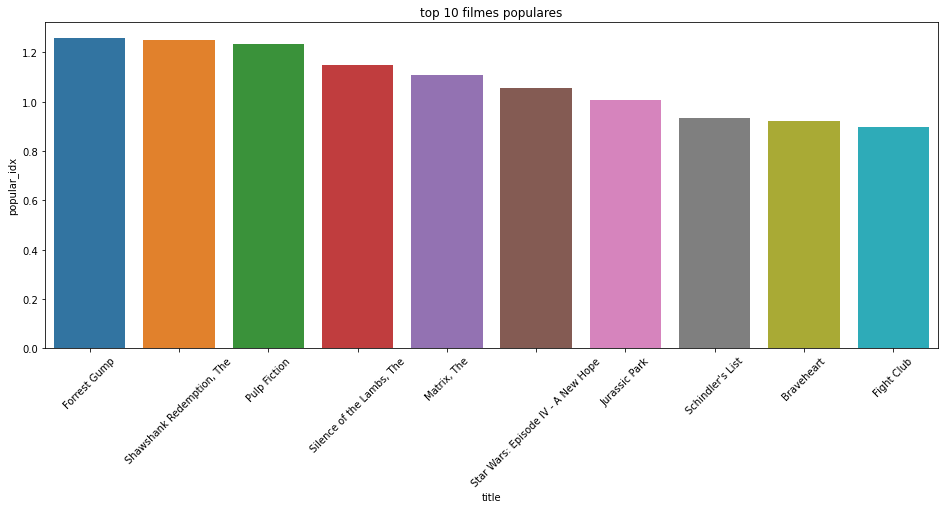

In [54]:
plt.figure(figsize=(16,6))
plt.xticks(rotation=45)
plt.title('top 10 filmes populares')
sns.barplot(data=df_top10_pop_mov, x=df_top10_pop_mov.index, y='popular_idx')
plt.show()

# Quais os gêneros mais indicados para investir, considerando a audiência? Se olhar as notas, ainda seriam esses os filmes?

In [55]:
movies_raw.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


|movie|genero|qty|
|-----|------|---|
|top gun|acao|10|
|top gun|romance|10|
|...|...|


In [56]:
df_movies.columns

Index(['title', 'release', 'outros', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'rating', 'votes_qtty',
       'votes_qtty_K', 'popular_idx'],
      dtype='object')

In [57]:
df_genres_analysis = df_movies[['title', 'outros', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'votes_qtty']].copy()

df_genres_analysis   

,title,outros,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,votes_qtty
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,55667.0
2,Jumanji,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,23789.0
3,Grumpier Old Men,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,11681.0
4,Waiting to Exhale,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,2501.0
5,Father of the Bride Part II,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,11558.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209157,We,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0
209159,Window of the Soul,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.0
209163,Bad Poems,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1.0


In [58]:
colunas_genres = ['outros', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western']

In [59]:
df_genres_final = pd.melt(df_genres_analysis, id_vars=['title','votes_qtty'], value_vars=colunas_genres, ignore_index=False)


In [60]:
df_genres_final['title'].sort_values() #checando o melt 

movieId
208297    "BLOW THE NIGHT!" Let's Spend the Night Together
208297    "BLOW THE NIGHT!" Let's Spend the Night Together
208297    "BLOW THE NIGHT!" Let's Spend the Night Together
208297    "BLOW THE NIGHT!" Let's Spend the Night Together
208297    "BLOW THE NIGHT!" Let's Spend the Night Together
                                ...                       
157314                                                줄탁동시
157314                                                줄탁동시
157314                                                줄탁동시
157314                                                줄탁동시
157314                                                줄탁동시
Name: title, Length: 1248460, dtype: object

In [61]:
df_genres_final.head()

,title,votes_qtty,variable,value
movieId,,,,
1,Toy Story,55667.0,outros,0
2,Jumanji,23789.0,outros,0
3,Grumpier Old Men,11681.0,outros,0
4,Waiting to Exhale,2501.0,outros,0
5,Father of the Bride Part II,11558.0,outros,0


In [62]:
# df_genres_final.drop(['value'], inplace=True, axis=1)

In [63]:
df_genres_final.rename(columns={'variable':'genre'}, inplace=True)
df_genres_final.head()

,title,votes_qtty,genre,value
movieId,,,,
1,Toy Story,55667.0,outros,0
2,Jumanji,23789.0,outros,0
3,Grumpier Old Men,11681.0,outros,0
4,Waiting to Exhale,2501.0,outros,0
5,Father of the Bride Part II,11558.0,outros,0


In [64]:
df_genres_final = df_genres_final[df_genres_final['value']==1]

In [65]:
df_genres_final.groupby('genre')['votes_qtty'].sum().sort_values(ascending=False)

genre
Drama          10698791.0
Comedy          8745445.0
Action          7242932.0
Thriller        6599145.0
Adventure       5666671.0
Romance         4403141.0
Sci-Fi          4200225.0
Crime           4078394.0
Fantasy         2753784.0
Children        2069990.0
Mystery         1957266.0
Horror          1855334.0
Animation       1581076.0
War             1233178.0
IMAX            1013989.0
Musical          945693.0
Western          473564.0
Documentary      316935.0
Film-Noir        240929.0
outros            25633.0
Name: votes_qtty, dtype: float64

In [66]:
df_final_final = pd.DataFrame(
    df_genres_final.groupby('genre')['votes_qtty'].sum() / df_genres_final.groupby('genre')['value'].sum()
    ,columns = ['valores']
).sort_values(by='valores',ascending=False)

In [67]:
df_final_final #valores significa quantidade de votos

,valores
genre,
IMAX,5199.943590
Adventure,1367.110012
Sci-Fi,1168.351878
Fantasy,1008.342732
Action,985.701143
Musical,897.241935
Crime,766.759541
Thriller,762.554310
Children,705.277683
